In [1]:
%load_ext autoreload
%autoreload 2

import os
from operator import attrgetter
from platform import python_version_tuple

xrange = range

import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.measure
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from extract_data import *

In [2]:
skimage.__version__

'0.18.2'

In [3]:
h5f = h5py.File(os.path.join(os.path.dirname(os.getcwd()), 'data', 'hdf5_datasets', 'DRIONS-DB.hdf5'), 'a')

In [4]:
X, disc, file_codes = extract_DRIONS_DB(os.path.join(os.path.dirname(os.getcwd()), 'data', 'DRIONS-DB'))
len(X), X[0].shape, len(disc), disc[0].shape, len(file_codes)

(110, (560, 560, 3), 110, (560, 560, 1), 110)

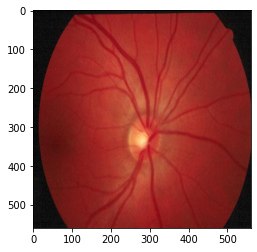

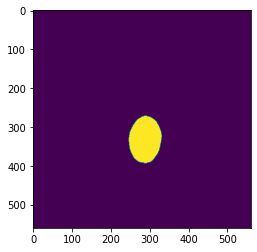

In [6]:
for i in xrange(1):
    cur = X[i].copy()
    cur[np.where(disc[i])] /= 4
    plt.imshow(X[i])
    plt.show()
    plt.imshow(disc[i])
    plt.show()

In [7]:
resolution = get_resolution_DRIONS_DB()
str_dt = h5py.special_dtype(vlen=str)

In [8]:
db = 'DRIONS-DB'
X_ds = np.array(X)
disc_ds = np.array(disc)
file_codes_ds = np.array(file_codes)
resolutions = (512, 256, 128)

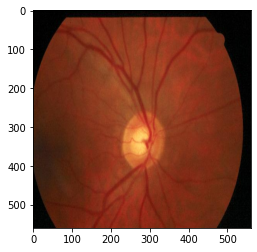

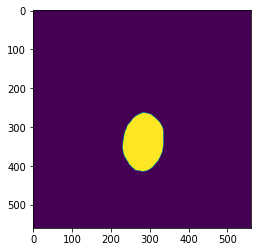

110

In [9]:
plt.imshow(X_ds[10])
plt.show()
plt.imshow(disc_ds[10])
plt.show()
X_ds.shape[0]

In [10]:
for res in resolutions:
    print('Copying data for {}, resolution {}'.format(db, res))
    
    X_small_ds = h5f.create_dataset( "{}/{} px/images".format(db, res), 
                                    (X_ds.shape[0], res, res, 3,), 
                                    chunks=(2, res, res, 3,),
                                    dtype=X_ds.dtype, compression="gzip")
    
    disc_small_ds = h5f.create_dataset("{}/{} px/disc".format(db, res), 
                                       (X_ds.shape[0], res, res, 1,),  
                                       chunks=(2, res, res, 1,),
                                       dtype=disc_ds.dtype, compression="gzip")
    
    str_dt = h5py.special_dtype(vlen=str)
    file_codes_small_ds = h5f.create_dataset("{}/{} px/file_codes".format(db, res), 
                                             (X_ds.shape[0],),  
                                             chunks=True, 
                                             dtype=str_dt, compression="gzip")
    
    file_codes_small_ds[:] = file_codes_ds[:]
    
    for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):
        X_small_ds[i] = resize(X_ds[i], (res, res))
        cur_disc_small = resize(disc_ds[i][..., 0], (res, res))
        disc_small_ds[i] = cur_disc_small[..., np.newaxis]

Copying data for DRIONS-DB, resolution 512


<ipython-input-10-9f86cf604b9a>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds.shape[0]), leave=True):



Copying data for DRIONS-DB, resolution 256



Copying data for DRIONS-DB, resolution 128


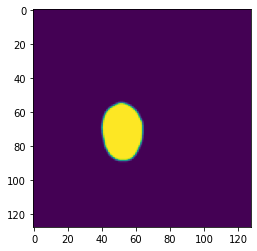

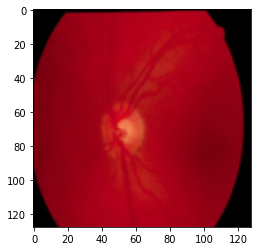

In [11]:
plt.imshow(disc_small_ds[100]);plt.show()
plt.imshow(X_small_ds[100]);plt.show()

In [12]:
print('Saving disc bbox coordinates for DRIONS-DB')
X_ds_orig = h5f['DRIONS-DB/512 px/images']
disc_ds_orig = h5f['DRIONS-DB/512 px/disc']

Saving disc bbox coordinates for DRIONS-DB


In [13]:
res = 512
gap = 20
standard_res = (512, 512)
disc_locations = np.empty((X_ds.shape[0], 4), dtype=np.int64)

img_ds = h5f.create_dataset('DRIONS-DB/512 px/img_cropped_gap_20', 
                                (X_ds.shape[0], res, res, 3,), 
                                chunks=(2, res, res, 3,),
                                dtype=X_ds.dtype, compression="gzip")

disc_ds = h5f.create_dataset('DRIONS-DB/512 px/disc_cropped_gap_20', 
                                   (X_ds.shape[0], res, res, 1,),  
                                   chunks=(2, res, res, 1,),
                                   dtype=disc_ds_orig.dtype, compression="gzip")

for i in tqdm_notebook(xrange(X_ds_orig.shape[0]), leave=True):
    img = X_ds_orig[i]
    disc = disc_ds_orig[i, ..., 0]
    
    labeled = skimage.measure.label(np.ceil(disc))
    region_props = skimage.measure.regionprops(labeled)
    component = max(region_props, key=attrgetter('area'))    # there should be only 1 component, 
                                                             # so this is a safety measure
    disc_locations[i][0] = max(component.bbox[0] - gap, 0)
    disc_locations[i][1] = max(component.bbox[1] - gap, 0)
    disc_locations[i][2] = min(component.bbox[2] + gap, img.shape[0] - 1)
    disc_locations[i][3] = min(component.bbox[3] + gap, img.shape[1] - 1)
    
    img_cur_cropped = img[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    img_cur_cropped = resize(img_cur_cropped, standard_res)
    img_ds[i] = img_cur_cropped
    
    disc_cur_cropped = disc[disc_locations[i][0]:disc_locations[i][2],
                           disc_locations[i][1]:disc_locations[i][3]]
    disc_cur_cropped = resize(disc_cur_cropped, standard_res)    
    disc_ds[i, ..., 0] = disc_cur_cropped


<ipython-input-13-a6fb4b6bb670>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(xrange(X_ds_orig.shape[0]), leave=True):


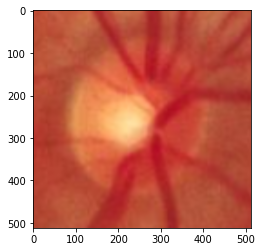

In [14]:
plt.imshow(img_ds[0])

In [15]:
h5f.close()